## Imports

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import sys
import numpy as np
from torch import nn
from torchvision.transforms.functional import pil_to_tensor
from torchvision import datasets, transforms #currently unused
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from scipy.signal import argrelextrema
import pandas as pd
print("ok")


ok


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "xpu"
    if torch.xpu.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using xpu device


2026-01-25 16:11:07.516115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-25 16:11:07.605035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-25 16:11:09.626806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Parameters and Hyperparameters

In [4]:
num_epochs = 10
img_width = 200
img_height = 50
num_characters = 26 #TODO: change for function

## create segment

In [5]:
from utils import SplitImage

si = SplitImage("src/pmml_project/img/a01-043.png")
handwritten_area = si.handwritten_area()
handwritten_area.save('handwritten-a01-043.png')



### Create the horizontal projection of gray values

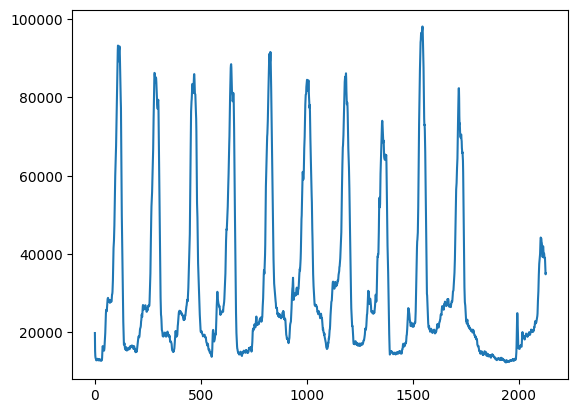

In [5]:
img = Image.open("handwritten-a01-043.png")
pixels = np.array(img)
horizontal_projection = np.sum(255 - pixels, axis=1)
plt.plot(horizontal_projection)
plt.show()

### Find local minima

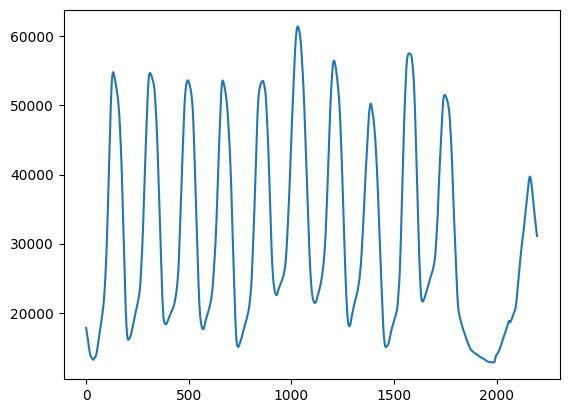

In [6]:
# code from https://www.kaggle.com/code/irinaabdullaeva/text-segmentation

def smooth(x, window_len=70, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

smoothed = smooth(horizontal_projection, 70, window='flat')
plt.plot(smoothed)

local_minima = argrelextrema(smoothed, np.less)
local_minima = np.array(local_minima).flatten()

### Cropping lines

[(0, 205), (205, 389), (389, 571), (571, 741), (741, 927), (927, 1114), (1114, 1282), (1282, 1460), (1460, 1639), (1639, 1980)]


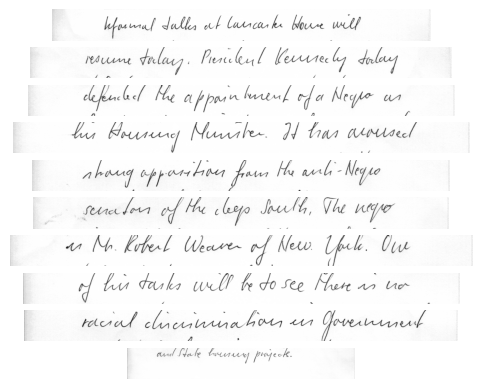

In [15]:
def crop_lines(local_minima, threshold=0):
    x1 = 0
    cropped = []
    diff = []
    for i, min in enumerate(local_minima):
        x2 = min
        #print(f"x1 = {x1}, x2 = {x2}, diff = {x2-x1}")
        if x2-x1 >= threshold:
            cropped.append((x1, x2))
        x1 = min
    return cropped

def show_cropped_lines(img, cropped):
    plots = len(cropped)
    for i, l in enumerate(cropped):
        line = img[l[0]:l[1]]
        plt.subplot(plots, 1, i+1)
        plt.axis('off')

        _ = plt.imshow(line, cmap='gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

cropped = crop_lines(local_minima, 100)
cropped = [(int(x1), int(x2)) for x1, x2 in cropped]
print(cropped)
show_cropped_lines(pixels, cropped)

### Preparing the Dataset

In [4]:
df = pd.read_csv("segments.csv", delimiter="\t")
df

,text_number,file_name,file_path,segment_start,segment_end,segment_text
0,a06-119,a06-119.png,/084/a06-119.png,718,893,Note circulation soared for the
1,a06-119,a06-119.png,/084/a06-119.png,901,1070,sixth successive week - this
2,a06-119,a06-119.png,/084/a06-119.png,1077,1250,"time by more than 15,000,000 last"
3,a06-119,a06-119.png,/084/a06-119.png,1259,1432,week. And that brought the figure
4,a06-119,a06-119.png,/084/a06-119.png,1438,1614,"to a record 2,415,000,000. This was"
...,...,...,...,...,...,...
4352,a01-014,a01-014x.png,/008/a01-014x.png,1745,1926,and the talks fall through. There are bound
4353,a01-014,a01-014x.png,/008/a01-014x.png,1926,2108,to be demonstrations.” Yesterday Sir Roy’s
4354,a01-014,a01-014x.png,/008/a01-014x.png,2108,2289,"chief aide, Mr. Julius Greenfield, telephoned"
4355,a01-014,a01-014x.png,/008/a01-014x.png,2289,2463,his chief a report on his talks with Mr.


In [21]:
#define nn datastructure
class OCR_dataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_path: str):
        self.df = df
        self.root_path = root_path

    def __len__(self):
        return len(df)

    def __getitem__(self, idx):
        path = self.root_path + self.df.iloc[idx]['file_path']
        start = self.df.iloc[idx]['segment_start']
        end = self.df.iloc[idx]['segment_end']
        text = self.df.iloc[idx]['segment_text']

        image = Image.open(path)
        width, _ = image.size
        image = image.crop((0, start, width, end))
        image = pil_to_tensor(image)
        return image, text

In [ ]:
root_path = "/home/jan/.cache/kagglehub/datasets/naderabdelghany/iam-handwritten-forms-dataset/versions/1/data"
data = OCR_dataset(df, root_path)
generator = torch.Generator().manual_seed(299792458) # Generator for reproducability
train_data, eval_data, test_data = random_split(data, [.8, .1, .1], generator)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=4,
    shuffle=True,
    num_workers=4
)
test_dataloader = DataLoader(
    dataset=eval_data,
    batch_size=4,
    shuffle=True,
    num_workers=4
)
eval_dataloader = DataLoader(
    dataset=test_data,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

### The Model

In [9]:
#define nn layers
class OCR_neural_network(nn.Module):
    def __init__(self, img_width, img_height, num_characters):
        super().__init__()
        self.rnn_height = img_height//4
        self.rnn_width = img_width//4
        self.rnn_feature_number = self.rnn_height * 64
        
        self.conv_pooling_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1),
            nn.ReLu(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLu(),
            nn.MaxPool2d(2)
        )

        self.after_resize_stack = nn.Sequential(
            nn.Linear(self.rnn_feature_number, 64),
            nn.ReLu(),
            nn.Dropout(0.2)
        )
            
        self.rnn1 = nn.LSTM(64, 128, batch_first = True, bidirectional = True, dropout = 0.25)
        self.rnn2 = nn.LSTM(256, 64, batch_first = True, bidirectional = True, dropout = 0.25)

        self.output_layer = nn.Linear(128, num_characters)
        
        def forward(self, x):
            batch_size, seq_len, channels, height = x.size()
            
            x = self.conv_pooling_stack(x)
    
            #reshape for rnn
            x = x.permute(0, 3, 1, 2)
            x = torch.reshape(x, (batch_size, seq_len, channels * height))    
            
            x = self.after_resize_stack(x)
    
            x, y = self.rnn1(x) #y is not used
            x, y = self.rnn2(x)
    
            x = self.output_layer(x)
            return x



In [ ]:
#create instance of model
model = OCR_neural_network(img_width, img_height, num_characters)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
#train NN
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for image_data, label in training_dataloader:
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss

    